In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the dataset
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
images = load_images_from_folder(dataset_folder)

In [ ]:
def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

**Blood Vessel Segmentation**

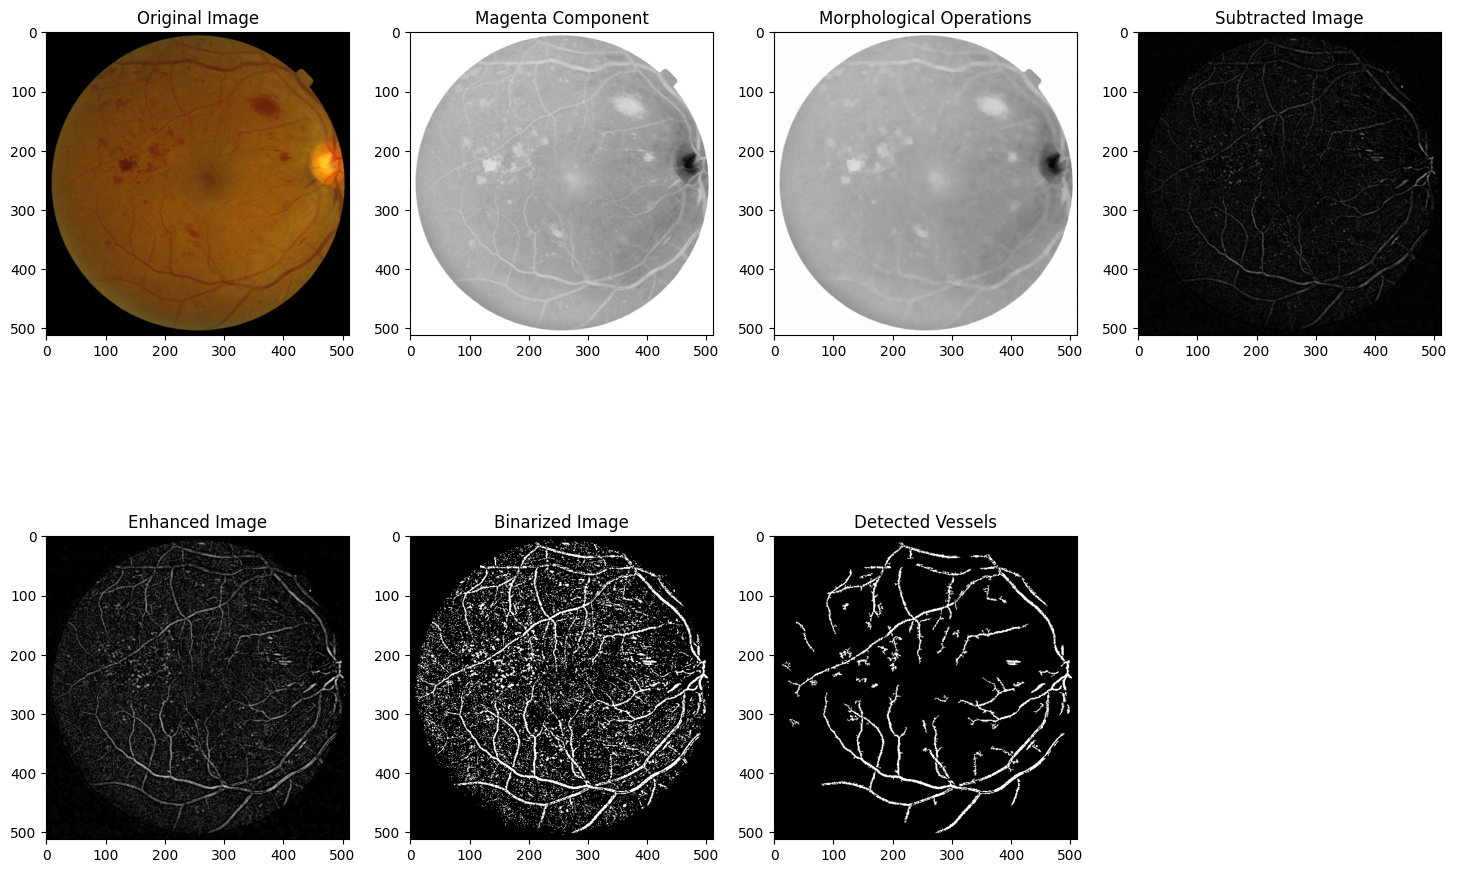

In [ ]:
# Convert RGB image to CMY and isolate magenta component
def rgb_to_cmy(image):
    return 1 - image / 255.0

def isolate_magenta(cmy_image):
    return cmy_image[:, :, 1]

# Apply morphological operations
def morphological_operations(image):
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(image, kernel, iterations=1)
    opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel)
    dilated = cv2.dilate(opened, kernel, iterations=1)
    return dilated

# Subtract morphological result from magenta component
def subtract_images(original, morphed):
    return cv2.subtract(original, morphed)

# Adaptive histogram equalization for contrast enhancement
def histogram_equalization(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(image)
    return equalized

# Binarize the image using global thresholding
def binarize_image(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    _, binary_image = cv2.threshold(image, 17, 255, cv2.THRESH_BINARY)
    return binary_image

# Reduce noise
def noise_reduction(binary_image):
    kernel = np.ones((1, 1), np.uint8)
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    num_labels, labels_im = cv2.connectedComponents(closed)

    for i in range(1, num_labels):
        if np.sum(labels_im == i) < 45:
            closed[labels_im == i] = 0

    return closed

# Compute blood vessel density
def compute_density(binary_image):
    white_pixels = np.sum(binary_image == 255)
    total_pixels = binary_image.size
    density = white_pixels / total_pixels
    return density

def process_image(image):
    cmy_image = rgb_to_cmy(image)
    magenta_component = isolate_magenta(cmy_image)
    morphed_image = morphological_operations(magenta_component)
    subtracted_image = subtract_images(magenta_component, morphed_image)
    enhanced_image = histogram_equalization(subtracted_image)
    binary_image = binarize_image(enhanced_image)
    final_image = noise_reduction(binary_image)
    density = compute_density(final_image)

    return magenta_component, morphed_image, subtracted_image, enhanced_image, binary_image, final_image, density

# filename = '20051020_45004_0100_PP.png' #ok
# filename = '20051021_39719_0100_PP.png'  #MA
filename = '20051214_52204_0100_PP.png' #HMR

dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
original_image = cv2.imread(file_path)

magenta_component, morphed_image, subtracted_image, enhanced_image, binary_image, final_image, density = process_image(original_image)

# Display the results
plt.figure(figsize=(18, 12))

plt.subplot(2, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 4, 2)
plt.title("Magenta Component")
plt.imshow(magenta_component, cmap='gray')

plt.subplot(2, 4, 3)
plt.title("Morphological Operations")
plt.imshow(morphed_image, cmap='gray')

plt.subplot(2, 4, 4)
plt.title("Subtracted Image")
plt.imshow(subtracted_image, cmap='gray')

plt.subplot(2, 4, 5)
plt.title("Enhanced Image")
plt.imshow(enhanced_image, cmap='gray')

plt.subplot(2, 4, 6)
plt.title("Binarized Image")
plt.imshow(binary_image, cmap='gray')

plt.subplot(2, 4, 7)
plt.title("Detected Vessels")
plt.imshow(final_image, cmap='gray')

plt.show()

**Optic Disc Segmentation**

18


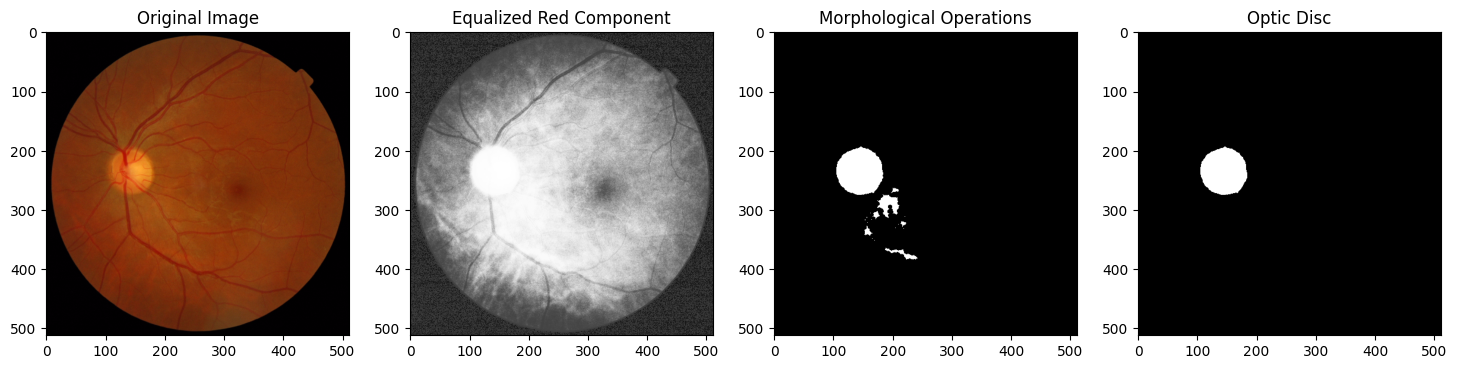

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_optic_disc(input_image):
    # Extract the red channel
    red_channel = input_image[:, :, 2]
    # Equalize the histogram of the red channel
    equalized_red_channel = cv2.equalizeHist(red_channel)
    max_intensity = np.max(red_channel)
    mean_intensity = np.mean(red_channel)
    # Count total pixels in the input image
    total_pixels = red_channel.size
    # Compute the histogram of the red channel
    histogram = cv2.calcHist([equalized_red_channel], [0], None, [256], [0, 256]).flatten()
    # Start with the maximum intensity as the initial threshold
    threshold_value = max_intensity - 1

    # Find the brightest region in the red channel
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(red_channel)
    brightest_point = max_loc  # Location of the brightest point

    # Iterate to find the appropriate threshold
    while threshold_value > 0:
        count_pixels = np.sum(histogram[threshold_value:])
        if count_pixels / total_pixels >= 0.025:
            break
        threshold_value -= 1
    # Apply binary thresholding
    _, binary_image = cv2.threshold(equalized_red_channel, threshold_value, 255, cv2.THRESH_BINARY)
    # Morphological closing to remove gaps in the optic disc boundary
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, structuring_element)
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))
    # Fit an ellipse to the largest contour
    output_image = np.zeros_like(binary_image)
    if contours:
        for contour in contours:
            distance = cv2.pointPolygonTest(contour, brightest_point, True)
            if distance >= 0:
                cv2.drawContours(output_image, [contour], -1, (255, 255, 0), -1)
                break
        structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        output_image = cv2.morphologyEx(output_image, cv2.MORPH_CLOSE, structuring_element)
    return output_image, equalized_red_channel, closed_image

filename = '20051020_56592_0100_PP.png'

dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
original_image = cv2.imread(file_path)

optic_disc, equalized_red_channel, closed_image = segment_optic_disc(original_image)

# Display the results
plt.figure(figsize=(18, 12))

plt.subplot(2, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 4, 2)
plt.title("Equalized Red Component")
plt.imshow(equalized_red_channel, cmap='gray')

plt.subplot(2, 4, 3)
plt.title("Morphological Operations")
plt.imshow(closed_image, cmap='gray')

plt.subplot(2, 4, 4)
plt.title("Optic Disc")
plt.imshow(optic_disc, cmap='gray')

plt.show()


**Fovea Detection**

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# filename = '20051021_39719_0100_PP.png' #MA

filename = '20051214_52204_0100_PP.png' #HMR

dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Adaptive Histogram Equalization (ADHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(image)

# Step 2: Morphological operations for noise removal
kernel = np.ones((7, 7), np.uint8)
closed_image = cv2.morphologyEx(enhanced_image, cv2.MORPH_CLOSE, kernel)

# Step 3: Thresholding
_, thresholded_image = cv2.threshold(closed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 4: Further noise removal by eliminating small areas
contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(thresholded_image)

for contour in contours:
    if cv2.contourArea(contour) > 25:
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

final_image_fovea = cv2.bitwise_and(closed_image, mask)

# Step 5: Define a rectangular ROI around the center
image_center = (image.shape[1] // 2, image.shape[0] // 2)
roi_width = 160  # Width of the rectangular region
roi_height = 100  # Height of the rectangular region
roi_x1 = max(image_center[0] - roi_width // 2, 0)
roi_x2 = min(image_center[0] + roi_width // 2, image.shape[1])
roi_y1 = max(image_center[1] - roi_height // 2, 0)
roi_y2 = min(image_center[1] + roi_height // 2, image.shape[0])

# Create a rectangular mask for the ROI
roi_mask = np.zeros_like(final_image_fovea)
roi_mask[roi_y1:roi_y2, roi_x1:roi_x2] = 255

# Find contours in the final image
contours, _ = cv2.findContours(final_image_fovea, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for regions within the ROI
roi_region_mask = np.zeros_like(final_image_fovea)

# Draw the regions within the ROI on the mask
for contour in contours:
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        if roi_x1 <= cX <= roi_x2 and roi_y1 <= cY <= roi_y2:
            cv2.drawContours(roi_region_mask, [contour], -1, (255), thickness=cv2.FILLED)

# Apply the ROI mask to isolate the fovea region
final_roi_image = cv2.bitwise_and(roi_region_mask, roi_mask)

# Create a mask with only the rectangular ROI (white) and other areas black
roi_only_mask = np.zeros_like(final_image_fovea)
roi_only_mask[roi_y1:roi_y2, roi_x1:roi_x2] = 255


**Microaneurysms Detection**

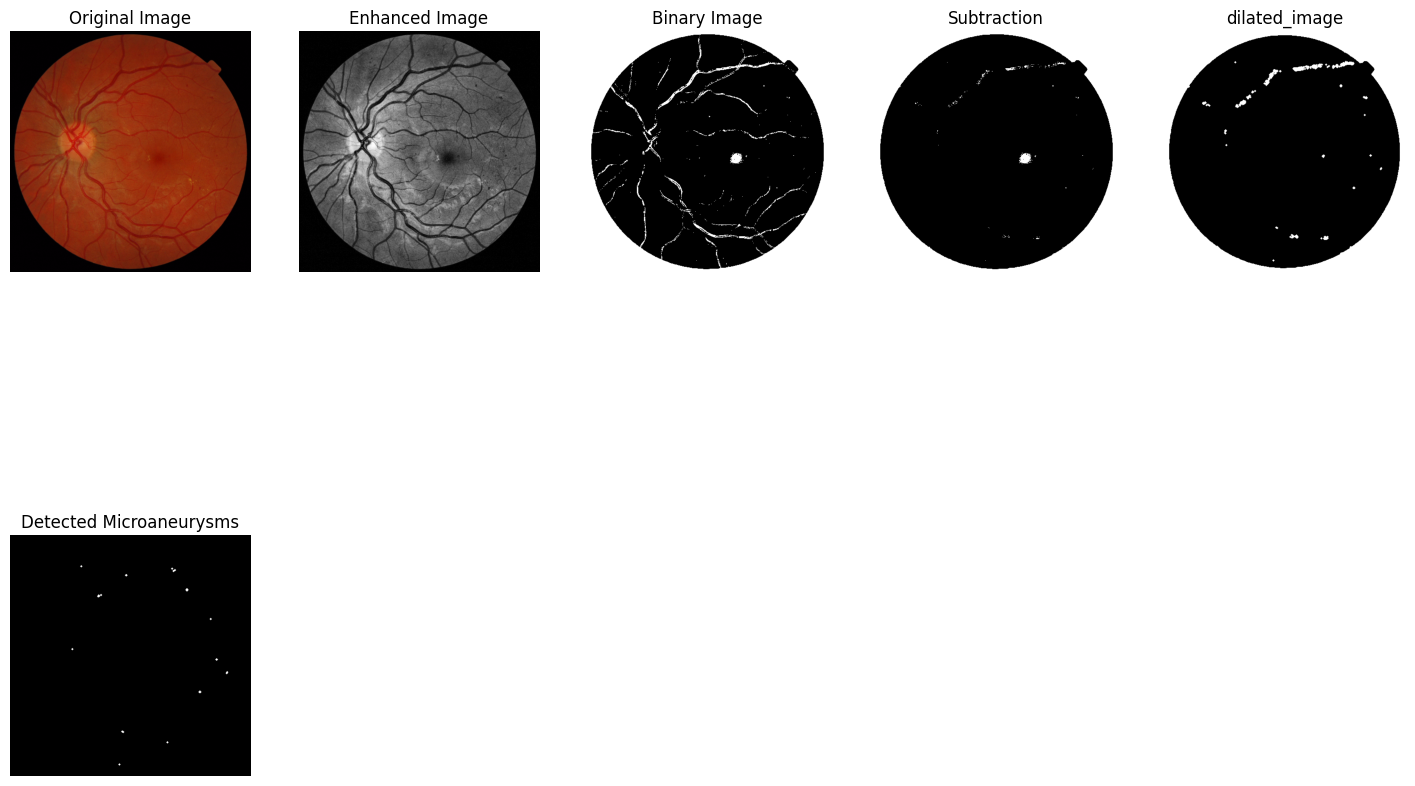

In [ ]:
import cv2
import os
import numpy as np

def detect_ma(image, blood_vessels_image, fovea):

    R, G, B = cv2.split(image)

    # Use adaptive histogram equalization to improve contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(G)

    # Threshold the image to create a binary image
    _, binary = cv2.threshold(enhanced, 30, 255, cv2.THRESH_BINARY_INV)

    difference = cv2.subtract(binary, blood_vessels_image)

    improved_image = difference.copy()
    improved_image[fovea == 255] = 0

    # Apply morphological operations to enhance the hemorrhage regions
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(improved_image, kernel1, iterations=2)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dilated_image, connectivity=4)

    # Get the area (size) of each component
    sizes = stats[:, -1]

    # Create an output image to store small items
    result_image = np.zeros_like(dilated_image)

    # Iterate through all detected components
    for i in range(1, num_labels):
        if sizes[i] < 33:
            result_image[labels == i] = 255

    number_of_ma = num_labels - 1
    ma_area = np.sum(result_image == 255)

    return enhanced, binary, difference, result_image, dilated_image

filename = '20051021_39719_0100_PP.png'

dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
original_image = cv2.imread(file_path)

blood_vessels = final_image
fovea = roi_only_mask

enhanced, binary, difference, result_image, dilated_image = detect_ma(original_image, blood_vessels, fovea)


# Display results
plt.figure(figsize=(18, 12))
plt.subplot(2, 5, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 5, 2)
plt.imshow(enhanced, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.subplot(2, 5, 3)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(2, 5, 4)
plt.imshow(difference, cmap='gray')
plt.title('Subtraction')
plt.axis('off')

plt.subplot(2, 5, 5)
plt.imshow(dilated_image, cmap='gray')
plt.title('dilated_image')
plt.axis('off')

plt.subplot(2, 5, 6)
plt.imshow(result_image, cmap='gray')
plt.title('Detected Microaneurysms')
plt.axis('off')

plt.show()

**Hemorrhages Detection**

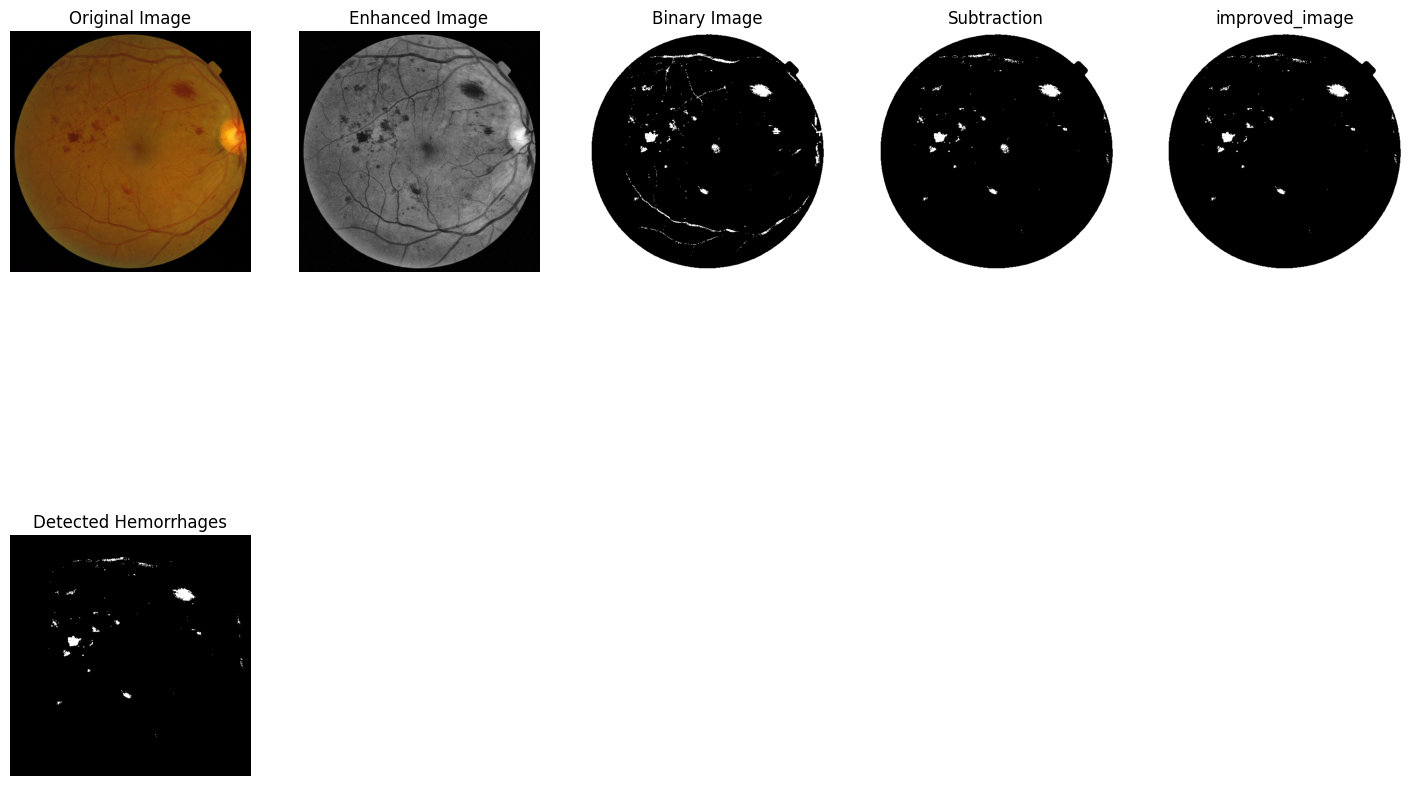

In [ ]:
import cv2
import os
import numpy as np

def detect_hemorrhages(image, blood_vessels_image):
    R, G, B = cv2.split(image)

    # Use adaptive histogram equalization to improve contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(G)

    # Threshold the image to create a binary image
    _, binary = cv2.threshold(enhanced, 48, 255, cv2.THRESH_BINARY_INV)
    difference = cv2.subtract(binary, blood_vessels_image)

    improved_image = difference.copy()
    improved_image[roi_only_mask == 255] = 0

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(improved_image, connectivity=8)
    sizes = stats[:, -1]

    result = np.zeros_like(improved_image)
    for i in range(1, num_labels):
        if sizes[i] < 1000:
            result[labels == i] = 255

    no_of_hmr = num_labels - 1
    hmr_area = np.sum(result == 255)

    return enhanced, binary, difference, result, improved_image

filename = '20051214_52204_0100_PP.png'
dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
original_image = cv2.imread(file_path)

blood_vessels = final_image

enhanced, binary, difference, detected_hemorrhages_image, improved_image = detect_hemorrhages(original_image, final_image)


# Display results
plt.figure(figsize=(18, 12))
plt.subplot(2, 5, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 5, 2)
plt.imshow(enhanced, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.subplot(2, 5, 3)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(2, 5, 4)
plt.imshow(difference, cmap='gray')
plt.title('Subtraction')
plt.axis('off')

plt.subplot(2, 5, 5)
plt.imshow(improved_image, cmap='gray')
plt.title('improved_image')
plt.axis('off')

plt.subplot(2, 5, 6)
plt.imshow(detected_hemorrhages_image, cmap='gray')
plt.title('Detected Hemorrhages')
plt.axis('off')

plt.show()


**Exudates Detection**

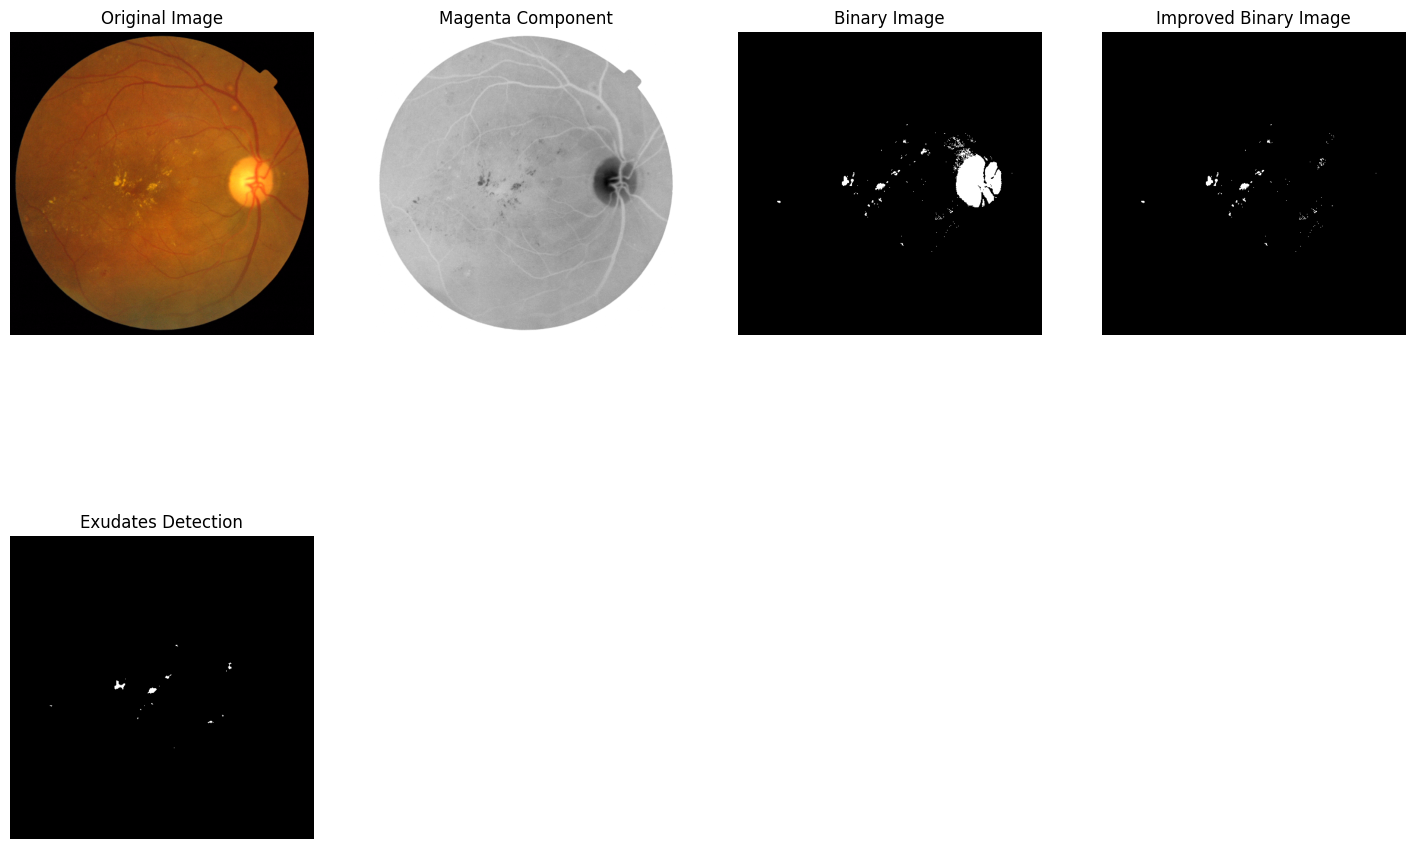

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rgb_to_cmy(image):
    return 1 - image / 255.0

def extract_magenta_component(cmy_image):
    return cmy_image[:, :, 1]

def threshold_binarization(magenta_component):
    std_dev = np.std(magenta_component)
    threshold = std_dev * 3.8
    _, binary_image = cv2.threshold(magenta_component, threshold, 1, cv2.THRESH_BINARY_INV)
    return binary_image

# Function to improve the binary image
def improve_binary_image(binary_image, optic_disc_mask):
    improved_image = binary_image.copy()
    improved_image[optic_disc_mask == 255] = 0  # Mask out optic-disc
    return improved_image

# Function for dilation
def dilate_image(binary_image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
    return dilated_image

# Function to remove large continuous regions
def remove_large_regions(dilated_image):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dilated_image.astype(np.uint8), connectivity=4)
    sizes = stats[:, -1]
    result_image = np.zeros_like(dilated_image)
    for i in range(1, num_labels):
        if sizes[i] < 1000:  # Threshold for large regions
            result_image[labels == i] = 1
    return result_image

# Function for erosion
def erode_image(binary_image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    return eroded_image

# Function to compute the density of hard exudates
def compute_density(binary_image):
    white_pixels = np.sum(binary_image == 1)
    total_pixels = binary_image.size
    density = white_pixels / total_pixels
    return density

def segment_optic_disc(input_image):
    red_channel = input_image[:, :, 2]
    # Equalize the histogram of the red channel
    equalized_red_channel = cv2.equalizeHist(red_channel)
    max_intensity = np.max(red_channel)
    mean_intensity = np.mean(red_channel)
    total_pixels = red_channel.size
    histogram = cv2.calcHist([equalized_red_channel], [0], None, [256], [0, 256]).flatten()
    threshold_value = max_intensity - 1
    # Find the brightest region in the red channel
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(red_channel)
    brightest_point = max_loc  # Location of the brightest point

    while threshold_value > 0:
        count_pixels = np.sum(histogram[threshold_value:])
        if count_pixels / total_pixels >= 0.0322:
            break
        threshold_value -= 1
    _, binary_image = cv2.threshold(equalized_red_channel, threshold_value, 255, cv2.THRESH_BINARY)
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, structuring_element)
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Fit an ellipse to the largest contour
    output_image = np.zeros_like(binary_image)
    if contours:
        for contour in contours:
            distance = cv2.pointPolygonTest(contour, brightest_point, True)
            if distance >= 0:
                cv2.drawContours(output_image, [contour], -1, (255, 255, 0), -1)
                break
        structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        output_image = cv2.morphologyEx(output_image, cv2.MORPH_CLOSE, structuring_element)
    return output_image

def detect_hard_exudates(image):
    cmy_image = rgb_to_cmy(image)
    magenta_component = extract_magenta_component(cmy_image)
    binary_image = threshold_binarization(magenta_component)

    # Extract optic-disc mask
    optic_disc_mask = segment_optic_disc(image)

    improved_image = improve_binary_image(binary_image, optic_disc_mask)
    dilated_image = dilate_image(improved_image)
    cleaned_image = remove_large_regions(dilated_image)
    final_image = erode_image(cleaned_image)
    density = compute_density(final_image)

    return magenta_component, binary_image, improved_image, final_image

filename = '20051214_51921_0100_PP.png'
dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
original_image = cv2.imread(file_path)

magenta_component, binary_image, improved_image, final_exudates_image = detect_hard_exudates(original_image)

plt.figure(figsize=(18, 12))
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(magenta_component, cmap='gray')
plt.title('Magenta Component')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(improved_image, cmap='gray')
plt.title('Improved Binary Image')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(final_exudates_image, cmap='gray')
plt.title('Exudates Detection')
plt.axis('off')

plt.show()


**Neovascularization**

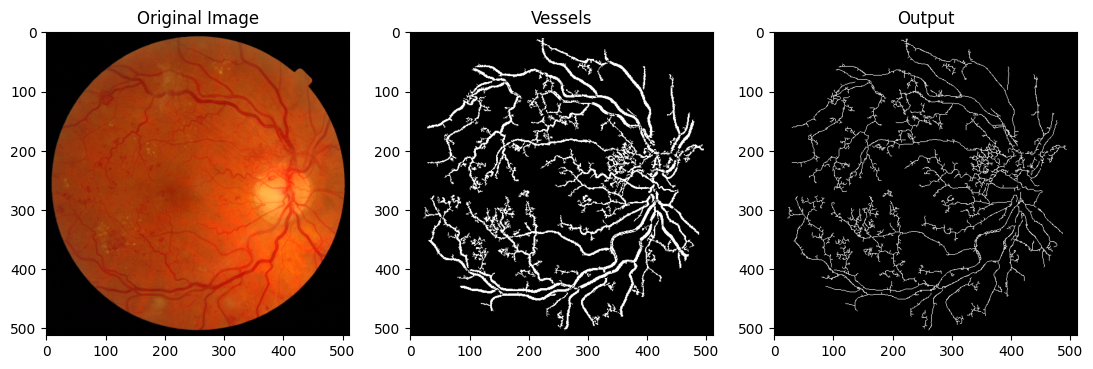

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def rgb_to_cmy(image):
    return 1 - image / 255.0

def isolate_magenta(cmy_image):
    return cmy_image[:, :, 1]

def morphological_operations(image):
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(image, kernel, iterations=1)
    opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel)
    dilated = cv2.dilate(opened, kernel, iterations=1)
    return dilated

def subtract_images(original, morphed):
    return cv2.subtract(original, morphed)

def histogram_equalization(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(image)
    return equalized

def binarize_image(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    _, binary_image = cv2.threshold(image, 17, 255, cv2.THRESH_BINARY)
    return binary_image

# Reduce noise
def reduce_noise(binary_image):
    kernel = np.ones((1, 1), np.uint8)
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return closed

# Additional noise reduction
def additional_noise_reduction(binary_image):
    num_labels, labels_im = cv2.connectedComponents(binary_image)

    for i in range(1, num_labels):
        if np.sum(labels_im == i) < 100:
            binary_image[labels_im == i] = 0

    return binary_image

def compute_density(binary_image):
    white_pixels = np.sum(binary_image == 255)
    total_pixels = binary_image.size
    density = white_pixels / total_pixels
    return density

# Skeletonization
def skeletonize(image):
    return cv2.ximgproc.thinning(image)

def analyze_tortuosity(skeleton):
    # Identify individual vessel segments
    num_labels, labels_im = cv2.connectedComponents(skeleton)

    # Initialize the new_vessels image
    new_vessels = np.zeros_like(skeleton)

    # Analyze each vessel segment
    for i in range(1, num_labels):
        segment = np.zeros_like(skeleton)
        segment[labels_im == i] = 255

        # Measure the length of the segment
        length = np.sum(segment > 0)

        # Measure the tortuosity (sum of angles between successive pixels)
        coords = np.column_stack(np.where(segment > 0))
        if len(coords) < 5:  # Skip very small segments
            continue

        total_angle = 0
        for j in range(1, len(coords) - 1):
            p1 = coords[j - 1]
            p2 = coords[j]
            p3 = coords[j + 1]
            v1 = p2 - p1
            v2 = p3 - p2
            angle = np.arctan2(np.linalg.det([v1, v2]), np.dot(v1, v2))
            total_angle += np.abs(angle)

        tortuosity = total_angle / length

        # High tortuosity and shorter length indicates new abnormal vessels
        if tortuosity > 0.7 and length < 120:
            new_vessels[labels_im == i] = 255

    return new_vessels

def process_image(image):
    cmy_image = rgb_to_cmy(image)
    magenta_component = isolate_magenta(cmy_image)
    morphed_image = morphological_operations(magenta_component)
    subtracted_image = subtract_images(magenta_component, morphed_image)
    enhanced_image = histogram_equalization(subtracted_image)
    binary_image = binarize_image(enhanced_image)
    noise_reduced_image = reduce_noise(binary_image)
    vessels = additional_noise_reduction(noise_reduced_image)

    # Skeletonize the final image
    skeleton = skeletonize(vessels)

    # Detect new abnormal vessels using curvature and tortuosity analysis
    new_vessels = analyze_tortuosity(skeleton)

    density = compute_density(new_vessels)

    return vessels, skeleton, new_vessels, density

filename = '20051020_45110_0100_PP.png' #High
# filename = '20060522_45541_0100_PP.png' #Low
# filename = '20051020_45004_0100_PP.png' #Normal

dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
original_image = cv2.imread(file_path)

vessels, skeleton, new_vessels, density = process_image(original_image)

plt.figure(figsize=(18, 12))

plt.subplot(2, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 4, 2)
plt.title("Vessels")
plt.imshow(vessels, cmap='gray')

plt.subplot(2, 4, 3)
plt.title("Output")
plt.imshow(skeleton, cmap='gray')

plt.show()


Std Deviation of RGB Components

In [ ]:
filename = '20051020_43906_0100_PP.png'
dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
image = cv2.imread(file_path)

b, g, r = cv2.split(image)

std_r = np.std(r)
std_g = np.std(g)
std_b = np.std(b)

print(f'Standard Deviation of Red Component: {std_r}')
print(f'Standard Deviation of Green Component: {std_g}')
print(f'Standard Deviation of Blue Component: {std_b}')

Standard Deviation of Red Component: 98.31673872911955
Standard Deviation of Green Component: 42.616474139172375
Standard Deviation of Blue Component: 23.746024435964507


Green Component Entropy

In [ ]:
def compute_entropy(image_channel):
    # Compute the histogram
    histogram, _ = np.histogram(image_channel.flatten(), bins=256, range=[0,256])

    # Normalize the histogram to get the probability distribution
    probability_distribution = histogram / histogram.sum()

    # Compute the entropy
    entropy = -np.sum(probability_distribution * np.log2(probability_distribution + 1e-10))

    return entropy

filename = '20051020_43906_0100_PP.png'
dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
image = cv2.imread(file_path)

b, g, r = cv2.split(image)

entropy_g = compute_entropy(g)

print(f'Entropy of the Green Component: {entropy_g}')

Entropy of the Green Component: 5.822974003720224


In [ ]:
import cv2
import numpy as np
from skimage import color
from skimage.feature import graycomatrix, graycoprops

filename = '20051020_43906_0100_PP.png'
dataset_folder = '/content/drive/MyDrive/Datasets/DR2/images'
file_path = os.path.join(dataset_folder, filename)
image = cv2.imread(file_path)
gray_image = color.rgb2gray(image)

# Compute the GLCM (Gray-Level Co-occurrence Matrix)
glcm = graycomatrix((gray_image * 255).astype(np.uint8), [1], [0], symmetric=True, normed=True)

# Compute texture features from the GLCM
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
contrast = graycoprops(glcm, 'contrast')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
entropy = -np.sum(energy * np.log2(energy + 1e-10))

print(f'Homogeneity: {homogeneity:.4f}')
print(f'Contrast: {contrast:.4f}')
print(f'Energy: {energy:.4f}')
print(f'Entropy: {entropy:.4f}')


Homogeneity: 0.4018
Contrast: 29.2944
Energy: 0.1361
Entropy: 0.3916


In [ ]:
import cv2
import numpy as np

def calculate_features(candidate_segment):
    # Convert candidate segment to float
    candidate_segment = candidate_segment.astype(float)

    # Energy
    energy = np.sum(candidate_segment ** 2)

    # Gradient calculation
    gradient_x = cv2.Sobel(candidate_segment, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(candidate_segment, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)

    # Mean Gradient
    mean_gradient = np.mean(gradient_magnitude)

    # Standard Deviation Gradient
    std_gradient = np.std(gradient_magnitude)

    # Mean Intensity
    mean_intensity = np.mean(candidate_segment)

    # Intensity Variation
    std_intensity = np.std(candidate_segment)
    intensity_variation = mean_intensity / (std_intensity + 1e-10)  # Adding a small epsilon to avoid division by zero

    features = {
        'Energy': energy,
        'Mean Gradient': mean_gradient,
        'Standard Deviation Gradient': std_gradient,
        'Mean Intensity': mean_intensity,
        'Intensity Variation': intensity_variation
    }

    return features

candidate_segment = skeleton
# Calculate features for the candidate segment
features = calculate_features(candidate_segment)
print(features)


{'Energy': 844154550.0, 'Mean Gradient': 100.81109502190151, 'Standard Deviation Gradient': 263.0201682947742, 'Mean Intensity': 12.628211975097656, 'Intensity Variation': 0.22826004485271523}
